In [2]:
import numpy as np
from torch import Tensor
from MLCode.utils import load_shuffled_cup, np_cup_TR, plot_NN_TR_VAL
from sklearn.preprocessing import StandardScaler
from MLCode.NN import NN_HyperParameters
from MLCode.NN_cup import NN_Regressor, train_NN_cup, save_training, train_NN_K_validation, saved_NN_models
import matplotlib.pyplot as plt

In [3]:
df = load_shuffled_cup()
X_dev, Y_dev = np_cup_TR(df, test=False)

Y_scaler = StandardScaler()
Y_scaler.fit(Y_dev)

X_dev, Y_dev = Tensor(X_dev), Tensor(Y_dev)

# 20% validation
val_samples = X_dev.shape[0] // 5
X_train = X_dev[:-val_samples]
Y_train = Y_dev[:-val_samples]

X_val = X_dev[-val_samples:]
Y_val = Y_dev[-val_samples:]

In [27]:
NN_HP = NN_HyperParameters(
    [10, 25, 25, 25, 25],
    lr=1E-2,
    beta1=0.9,
    beta2=0.999,
    weight_decay=0,
    mb_size=32,
)
net = NN_Regressor(2,NN_HP, Y_scaler)


# stats = train_NN_cup(net, X_train, Y_train, X_val, Y_val, 20,500)
stats = train_NN_K_validation(net, 5, X_dev, Y_dev)
save_training(stats, NN_HP)

layers = [ 10, 25, 25, 25, 25,]
lr = 0.015
beta1 = 0.9
beta2 = 0.999
weight_decay = 0
mb_size = 32

MEE mean: 2.9626412057857605
MEE std: 0.12260487972844275
Time (seconds): 17.072355235000032
Convergence: True


In [34]:
df = saved_NN_models()
df = df.sort_values(by=['MEE_mean'])
# select on number of layers:
# df = df[df['model_name'].str.startswith('3')]
df.head(10)


,model_name,MEE_mean,MEE_std
14,6x10_1.0E-02,2.932165,0.204040
2,5x15_1.0E-02,2.937914,0.151128
10,6x25_1.0E-02,2.957049,0.135452
51,4x15_1.0E-02,2.958287,0.146356
44,5x25_1.0E-02,2.982229,0.164257
12,5x15_1.0E-03,2.983944,0.200041
45,5x25_1.0E-03,2.984846,0.150048
71,6x50_1.0E-03,2.985802,0.128104
53,6x25_1.0E-03,2.986966,0.132031
63,5x15_2.0E-02,2.989739,0.160229


In [35]:
import pandas as pd
import seaborn as sns

df = saved_NN_models()
df = df.sort_values(by=['model_name'])
# select on number of layers:
df = df[df['model_name'].str.startswith('2')]

array = df['model_name'].to_numpy()
array = array.reshape(-1,4).transpose()
df2 = pd.DataFrame(array)
df2 = df2.reindex([3,0,1,2])
first_row = df2.iloc[0]
first_row = first_row.str.extract(pat = 'x(\d+)')[0]
n_hidden = first_row.astype('int')
col_order = n_hidden.to_numpy().argsort()
df2 = df2[col_order]
df2

,2,3,4,0,1
3,2x25_2.0E-02,2x50_2.0E-02,2x80_2.0E-02,2x100_2.0E-02,2x150_2.0E-02
0,2x25_1.0E-02,2x50_1.0E-02,2x80_1.0E-02,2x100_1.0E-02,2x150_1.0E-02
1,2x25_1.0E-03,2x50_1.0E-03,2x80_1.0E-03,2x100_1.0E-03,2x150_1.0E-03
2,2x25_1.0E-04,2x50_1.0E-04,2x80_1.0E-04,2x100_1.0E-04,2x150_1.0E-04


In [36]:
array = df['MEE_mean'].to_numpy()
array = array.reshape(-1,4).transpose()
df2 = pd.DataFrame(array)
df2 = df2.reindex([3,0,1,2])
df2 = df2[col_order]
df2

,2,3,4,0,1
3,3.015680,3.072003,3.055449,3.070301,3.065065
0,3.048910,3.012351,3.012317,3.017681,3.057486
1,3.179805,3.139962,3.117993,3.151567,3.112522
2,3.426612,3.407172,3.264274,3.249706,3.192345


' '

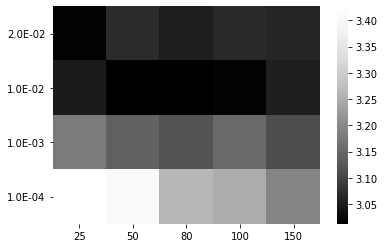

In [38]:
xticklabels = n_hidden[col_order]
yticklabels = ['2.0E-02', '1.0E-02', '1.0E-03', '1.0E-04']
sns.heatmap(df2.to_numpy(), xticklabels=xticklabels,yticklabels=yticklabels,cmap='Greys_r')
plt.yticks(rotation=0)
' '